### Plot depth-averaged upper 500 m speed differences from piControl for AntwaterStress experiments

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
import matplotlib.path as mpath
from scipy.io import loadmat
import mat73
from xgcm import Grid

import warnings
warnings.simplefilter("ignore")

from dask.distributed import Client
from dask.distributed import LocalCluster 

cluster = LocalCluster()
client = Client(cluster) 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37273/status,
Dashboard: http://127.0.0.1:37273/status,Workers: 4
Total threads: 8,Total memory: 30.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45740,Workers: 4
Dashboard: http://127.0.0.1:37273/status,Total threads: 8
Started: Just now,Total memory: 30.94 GiB
Comm: tcp://127.0.0.1:44645,Total threads: 2
Dashboard: http://127.0.0.1:46723/status,Memory: 7.73 GiB
Nanny: tcp://127.0.0.1:44662,


### Load CM4 control velocity output

In [33]:
CM4_ocean_static = xr.open_dataset('/net/Rebecca.Beadling/subtropical_gyres/mode_water/ocean_monthly.static.nc')
CM4_v_cntrl = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/piControl_output/ocean_annual_z.0281-0380.vo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'time':10,'yq':80})
CM4_u_cntrl = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/piControl_output/ocean_annual_z.0281-0380.uo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'time':10,'yh':80})
CM4_cntrl_velocity = xr.merge([CM4_v_cntrl,CM4_u_cntrl],compat='override')

### Load CM4 AntwaterStress ensemble members

In [34]:
AntwaterStress_251_v = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_output/ocean_annual_z.0051-0070.vo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'yq':80})
AntwaterStress_251_u = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_output/ocean_annual_z.0051-0070.uo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'yh':80})

AntwaterStress_290_v = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_290/ocean_annual_z.0051-0070.vo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'yq':80})
AntwaterStress_290_u = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_290/ocean_annual_z.0051-0070.uo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'yh':80})

AntwaterStress_332_v = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_332/ocean_annual_z.0051-0070.vo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'yq':80})
AntwaterStress_332_u = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_332/ocean_annual_z.0051-0070.uo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'yh':80})

AntwaterStress_velocity_251 = xr.merge([AntwaterStress_251_v,AntwaterStress_251_u],compat='override')
AntwaterStress_velocity_290 = xr.merge([AntwaterStress_290_v,AntwaterStress_290_u],compat='override')
AntwaterStress_velocity_332 = xr.merge([AntwaterStress_332_v,AntwaterStress_332_u],compat='override')

In [35]:
CM4_cntrl_velocity.vo

,Array,Chunk
Bytes,8.11 GiB,61.52 MiB
Shape,"(100, 14, 1080, 1440)","(10, 14, 80, 1440)"
Count,141 Tasks,140 Chunks
Type,float32,numpy.ndarray


### Compute 0 to 500 m depth-averaged (thickness weighted) ocean speed for the CM4 piControl experiment. The ocean component of CM4 and ESM4, MOM6, also uses an Arakawa-C Grid, where tracers are located at the cell centers, u falls on the interface of the tracer cells in the zonal direction (left T cell face), and v falls on the interface of the tracer cell in the meridional direction (front T cell face). To compute speed, one must interpolate u or v onto the other position. We do this using xgcm.

In [41]:
cm4_grid = Grid(CM4_cntrl_velocity, coords={'X': {'center': 'xh', 'right': 'xq'},
                                            'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X','Y'])

cm4_v_cntrl = cm4_grid.interp(CM4_cntrl_velocity.vo,'Y', boundary='fill')
cm4_v_cntrl = cm4_grid.interp(cm4_v_cntrl,'X',boundary='fill') 

cm4_v_cntrl_sqr = xr.ufuncs.square(cm4_v_cntrl)
cm4_u_cntrl_sqr = xr.ufuncs.square(CM4_cntrl_velocity.uo)
speed_cm4_cntrl = xr.ufuncs.sqrt(cm4_v_cntrl_sqr + cm4_u_cntrl_sqr)

## volume-weighted depth-average
cm4_volume = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafstress_output/ocean_annual_z.0001-0070.volcello.nc').isel(time=0)
## volume is on xh, yh - so we need to interpolate to xq, yh
cm4_vol = cm4_grid.interp(cm4_volume.volcello, 'X', boundary='fill')
cm4_vol_weights = cm4_vol.sel(z_l=slice(0,500)).fillna(0)
cm4_speed_weighted = speed_cm4_cntrl.weighted(cm4_vol_weights)
cm4_speed_weighted_0_to_500_ave = cm4_speed_weighted.mean(dim=['z_l','time'])*100
cm4_speed_weighted_0_to_500_ave.load()

<xarray.DataArray (yh: 1080, xq: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xq       (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16

### Compute ocean speed for the CM4 AntwaterStress members and then compute ensemble mean.

In [42]:
AntwaterStress_v_251 = cm4_grid.interp(AntwaterStress_velocity_251.vo,'Y', boundary='fill')
AntwaterStress_v_251 = cm4_grid.interp(AntwaterStress_v_251,'X',boundary='fill') 

AntwaterStress_v_251_sqr = xr.ufuncs.square(AntwaterStress_v_251)
AntwaterStress_u_251_sqr = xr.ufuncs.square(AntwaterStress_velocity_251.uo)
speed_AntwaterStress_251 = xr.ufuncs.sqrt(AntwaterStress_v_251_sqr + AntwaterStress_u_251_sqr)

In [43]:
AntwaterStress_v_290 = cm4_grid.interp(AntwaterStress_velocity_290.vo,'Y', boundary='fill')
AntwaterStress_v_290 = cm4_grid.interp(AntwaterStress_v_290,'X',boundary='fill') 

AntwaterStress_v_290_sqr = xr.ufuncs.square(AntwaterStress_v_290)
AntwaterStress_u_290_sqr = xr.ufuncs.square(AntwaterStress_velocity_290.uo)
speed_AntwaterStress_290 = xr.ufuncs.sqrt(AntwaterStress_v_290_sqr + AntwaterStress_u_290_sqr)

In [44]:
AntwaterStress_v_332 = cm4_grid.interp(AntwaterStress_velocity_332.vo,'Y', boundary='fill')
AntwaterStress_v_332 = cm4_grid.interp(AntwaterStress_v_332,'X',boundary='fill') 

AntwaterStress_v_332_sqr = xr.ufuncs.square(AntwaterStress_v_332)
AntwaterStress_u_332_sqr = xr.ufuncs.square(AntwaterStress_velocity_332.uo)
speed_AntwaterStress_332 = xr.ufuncs.sqrt(AntwaterStress_v_332_sqr + AntwaterStress_u_332_sqr)

In [54]:
### Ensemble means
AnwaterStress_speed_ens = xr.concat([speed_AntwaterStress_251,speed_AntwaterStress_290,speed_AntwaterStress_332],dim='member')
AnwaterStress_speed_ens_mean = AnwaterStress_speed_ens.mean(dim='member').mean(dim='time')

### Compute depth-weighted ocean speed for Ensemble mean and then compute difference from piControl

In [57]:
AntwaterStress_ens_mean_speed_weighted = AnwaterStress_speed_ens_mean.weighted(cm4_vol_weights)
AntwaterStress_ens_mean_weighted_0_to_500_ave = AntwaterStress_ens_mean_speed_weighted.mean(dim=['z_l'])*100
AntwaterStress_ens_mean_diff = AntwaterStress_ens_mean_weighted_0_to_500_ave  - cm4_speed_weighted_0_to_500_ave

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


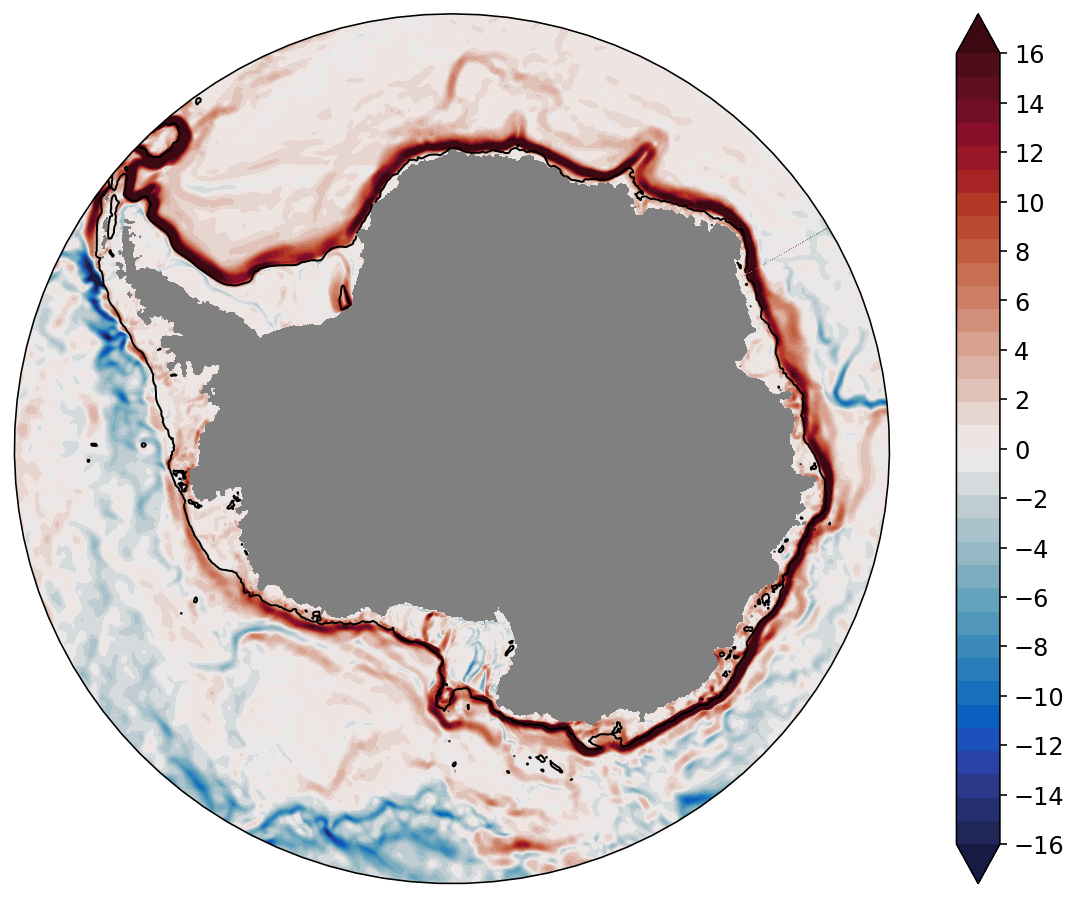

In [61]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=[12,8])

projection=ccrs.SouthPolarStereo(central_longitude = 0)
ax = plt.axes(projection=projection,facecolor='grey')
ax.set_extent([-180,180,-90,-60], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

p = AntwaterStress_ens_mean_diff.plot.contourf(x='xq', y='yh',vmin=-16,vmax=16,levels=35,
                        transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,add_colorbar=False)
CM4_ocean_static.deptho.plot.contour(transform=ccrs.PlateCarree(),colors='black',levels=[1000],linewidths=1)

cb = plt.colorbar(p, ticks=[-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16])
cb.ax.tick_params(labelsize=12)

plt.savefig('CM4_AntwaterStrress_ens_mean_Speed_Upper_500m.pdf')